### Deep Learning Course
     
2022/2023
***
Gonçalo Faria, Rita Ramos, Marcos Treviso
***
# Pytorch Basics

Pytorch is a platform for deep learning in Python/C++. It provides tools for efficiently creating, training, testing and analyzing neural networks. 

We divided the lab into 2 parts. 
* PART I : we intend to show you the fundamentals of how to use Pytorch. 
* PART II : we intend to convince you that Pytorch is a great tool for defining and training deep learning models. 

In [74]:
%matplotlib inline

In [75]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision

# selects a gpu for you, if you have one. 
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [76]:
from pprint import pprint

import matplotlib.pyplot as plt
import numpy as np
from IPython.core.debugger import set_trace

In [77]:
np.random.seed(0)
torch.manual_seed(0)

# PART I  - Pytorch Fundamentals
***


## Useful Functions
Pytorch (and other libraries) have many functions that operate on tensors. Let's try some of them and plot the results.

In [78]:
x = torch.arange(-10, 10, 0.1, dtype=torch.float)
x.shape

torch.Size([200])

Many functions are applied elementwise to the tensor: 
 - sin, cos, tan, tanh,.... (and other functions from trigonometry), exp, log, sigmoid, relu, abs, clamp, ceil, clip, round, sqrt ...

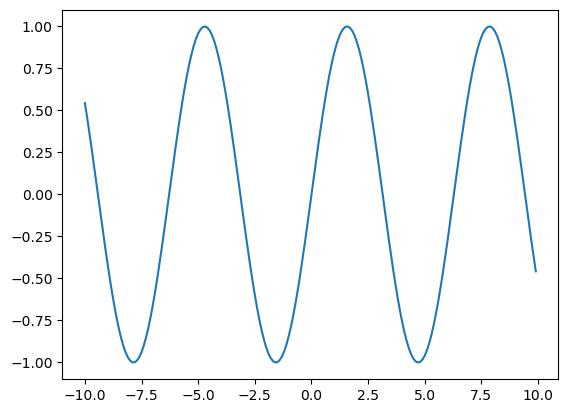

In [79]:
# sin, tanh, exp, log, sigmoid, relu, abs, clamp, ceil, clip, round, sqrt
y = torch.sin(x)
plt.plot(x, y)

Many functions are applied to a specific axis and reduce the dimentionality of the tensor:
 - argmax, argmin, max, min, sum, mean, std, any, prod, all, median, cumsum, bincount ...

In [80]:
print(" x.sum() %s " % x.sum())
print(" x.sum(axis=0) %s " % x.sum(axis=0))

 x.sum() tensor(-10.0000) 
 x.sum(axis=0) tensor(-10.0000) 


In [81]:
y = x.reshape(4, 5, 10)

print("x.shape : %s "% str(x.shape) )
print("y.shape : %s "% str(y.shape) )

x.shape : torch.Size([200]) 
y.shape : torch.Size([4, 5, 10]) 


In [82]:
print("y.sum(axis=1).shape : %s "% str(y.sum(axis=1).shape) )
print("y.sum(axis=0).shape : %s "% str(y.sum(axis=0).shape) )
print("y.sum(axis=[0,1]).shape : %s "% str(y.sum(axis=[0,1]).shape) )

y.sum(axis=1).shape : torch.Size([4, 10]) 
y.sum(axis=0).shape : torch.Size([5, 10]) 
y.sum(axis=[0,1]).shape : torch.Size([10]) 


# Automatic differentiation with `autograd`

Central to all neural networks in PyTorch is the `autograd` package. 

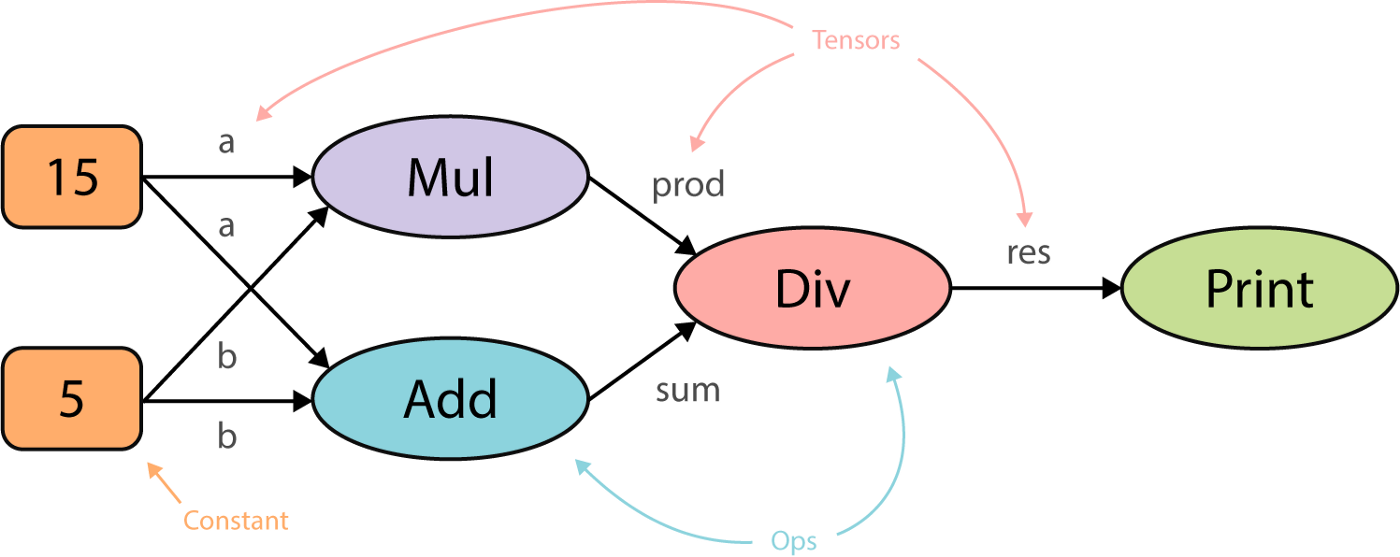

This is the _true_ power behind PyTorch. The autograd package provides automatic differentiation for all operations on Tensors. It is a **define-by-run** framework, which means that your backprop is defined by how your code is run, and that **every single iteration can be different**.

Refs:
- https://pytorch.org/docs/stable/autograd.html
- https://pytorch.org/tutorials/beginner/blitz/autograd_tutorial.html

`torch.Tensor` is the central class of the package. If you set its attribute `.requires_grad` as `True`, it starts to track all operations on it. When you finish your computation you can call `.backward()` and have all the gradients computed automatically. The gradient for this tensor will be accumulated into `.grad` attribute.

In [83]:
# setting requires_grad in directly via tensor's constructor
x = torch.tensor(2., requires_grad=False)

print(x)
# or by setting .requires_grad attribute
# you can do this at any moment to track operations on x
x.requires_grad = True  

print(x)

tensor(2.)
tensor(2., requires_grad=True)


Consider a simple function $y$ of $x$.

$ y(x) = x^2 $

$ \frac{\partial y}{\partial x}\bigg(x = 2\bigg) = 4$ // Evaluate derivative on x=2

In [ ]:
# let's perform a simple operation on x
y = x ** 2

print("Grad of y wrt x:", x.grad)

# if you want to compute the derivatives, you can call .backward() on a Tensor
y.backward()
print("Evaluate derivative of y w.r.t x at x=2:", x.grad)



Grad of y wrt x: None
Evaluate derivative of y w.r.t x at x=2: tensor(4.)


To stop a tensor from tracking history, you can call `.detach()` to detach it from the computation history, and to prevent future computation from being tracked. (i.e. everything that uses a variable with `.detach()` is treated as a constant )

To evaluate $ \frac{\partial y}{\partial x} $ on different values of x, we have to reset the values of x.grad.

In [85]:
y = x ** 2
y.backward()

print("Evaluate derivative of y w.r.t x at x=2 (a second time without reset):", x.grad)

x.grad.data.zero_()
y = x ** 2
y.backward()
print("Evaluate derivative of y w.r.t x at x=2 (a second time but with reset):", x.grad)


Evaluate derivative of y w.r.t x at x=2 (a second time without reset): tensor(8.)
Evaluate derivative of y w.r.t x at x=2 (a second time but with reset): tensor(4.)


For autograd to compute derivatives, it has to "track" ( save intermediate values ) of every computation. 

To prevent tracking history (and using memory), you can also wrap the code block in with `torch.no_grad()`:. This can be particularly helpful when evaluating a model because the model may have trainable parameters with `requires_grad=True`, but for which we don’t need the gradients.

In [86]:
x = torch.tensor(2.)
x.requires_grad = True
print('x:', x)

y = x ** 2
print('y:', y)

with torch.no_grad():
    y = 2 * y
    print('x:', x)  # Try to think why x.requires_grad is True
    print('y:', y)

x: tensor(2., requires_grad=True)
y: tensor(4., grad_fn=<PowBackward0>)
x: tensor(2., requires_grad=True)
y: tensor(8.)


# PART II - Linear Regression and Gradient Descent.
***

We will demonstrate why Pytorch, and neural network frameworks more generally, are particularly useful for researchers and practitioners.

Until now, you have been implementing neural networks by

A ) defining a model and loss function

B ) computin the gradients of the loss w.r.t the weights

C ) updating the weights using a first-order method.

Using Pytorch, you will still have to do A) and C). However, B) will be done automatically using automatic differentiation (**autograd**). Also, it provides support for training models using hardware accelerators ( like GPUs and TPUs ), and it contains many off-the-shelf implementations of state-of-the-art algorithms, architectures, and much more (https://pytorch.org/docs/stable/index.html).

In this part of the notebook we will compare how we perform linear regression: 
1. numpy
2. pytorch, but without making use of modules
3. pytorch with modules

# The Problem

(100, 1) (100,)


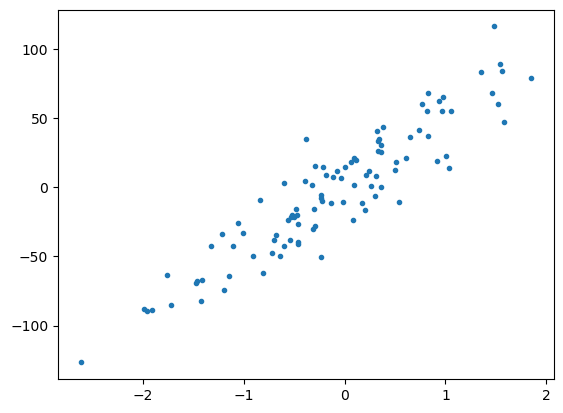

In [87]:
from sklearn.datasets import make_regression

n_features = 1
n_samples = 100

X, y = make_regression(
    n_samples=n_samples,
    n_features=n_features,
    noise=20,
    random_state=42,
)

fix, ax = plt.subplots()
ax.plot(X, y, ".")
print(X.shape, y.shape)

# Numpy Solution

In [88]:
class NumpyLinearRegression(object):
    def __init__(self, n_features, n_targets=1, lr=0.1):
        self.W = np.zeros((n_targets, n_features))
        self.lr = lr

    def update_weight(self, X, y):
        m = X.shape[0]
        y_hat = self.predict(X)
        W_grad = 2 * np.dot(X.T, y_hat - y) / m
        self.W = self.W - self.lr * W_grad

    def loss(self, y_hat, y):
        return np.mean(np.power(y_hat - y, 2))

    def predict(self, X):
        y_hat = np.dot(X, self.W.T)
        return y_hat.squeeze(-1)

    def train(self, X, y, epochs=50):
        """
        X (n_examples x n_features):
        y (n_examples): gold labels
        """
        loss_history = []
        for _ in range(epochs):
            # for x_i, y_i in zip(X, y):
            #        self.update_weight(x_i, y_i)
            self.update_weight(X, y)
            y_hat = self.predict(X)
            loss = self.loss(y_hat, y)
            loss_history.append(loss)
        return loss_history

In [89]:
use_bias = False
if use_bias:
    X_np = np.hstack([np.ones((n_samples,1)), X])
    n_features += 1
else:
    X_np = X

In [90]:
model = NumpyLinearRegression(n_features=n_features, n_targets=1, lr=0.1)
loss_history = model.train(X_np, y, epochs=50)
y_hat = model.predict(X_np)

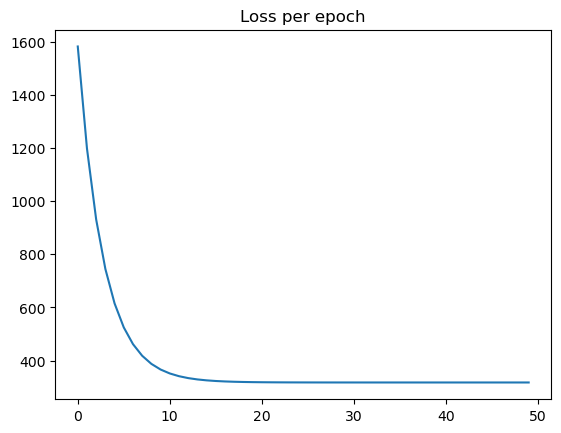

In [91]:
plt.plot(loss_history)
plt.title('Loss per epoch');

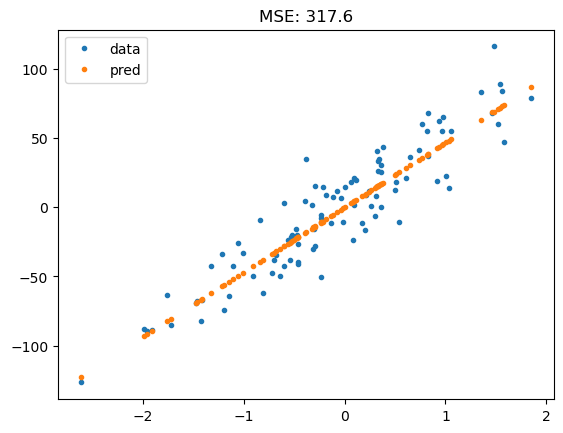

In [92]:
# Vis
fig, ax = plt.subplots()
ax.plot(X, y, ".", label="data")
ax.plot(X, y_hat, ".", label="pred")
ax.set_title(f"MSE: {loss_history[-1]:0.1f}")
ax.legend();

# PyTorch w/o modules

In [93]:
class PtLinearRegression(object):
    def __init__(self, n_features, n_targets=1, lr=0.01):
        self.W = torch.zeros(n_targets, n_features, requires_grad=True)  # note requires_grad=True!
        self.lr = lr
    
    def update_weight(self):
        # Gradients are given to us by autograd!
        self.W.data = self.W.data - self.lr * self.W.grad.data

    def loss(self, y_hat, y):
        return torch.mean(torch.pow(y_hat - y, 2))

    def predict(self, X):
        y_hat = torch.matmul(X, self.W.t())
        return y_hat.squeeze(-1)

    def train(self, X, y, epochs=50):
        """
        X (n_examples x n_features):
        y (n_examples): gold labels
        """
        loss_history = []
        for _ in range(epochs):
            
            # Our neural net is a Line function!
            y_hat = self.predict(X)
            
            # Compute the loss using torch operations so they are saved in the gradient history.
            loss = self.loss(y_hat, y)
            
            # Computes the gradient of loss with respect to all Variables with requires_grad=True.
            loss.backward()
            loss_history.append(loss.item())

            # Update a and b using gradient descent; a.data and b.data are Tensors.
            self.update_weight()

            # Reset the accumulated gradients
            self.W.grad.data.zero_()
            
        return loss_history

In [94]:
X_pt = torch.from_numpy(X_np).float()
y_pt = torch.from_numpy(y).float()

In [95]:
model = PtLinearRegression(n_features=n_features, n_targets=1, lr=0.1)
loss_history = model.train(X_pt, y_pt, epochs=50)
with torch.no_grad():
    y_hat = model.predict(X_pt)

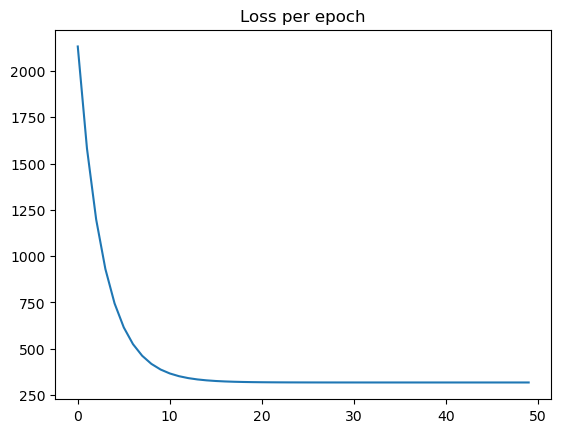

In [96]:
plt.plot(loss_history)
plt.title('Loss per epoch');

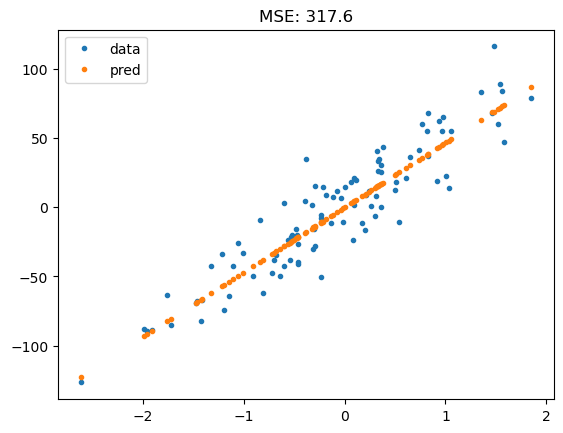

In [97]:
# Vis
fig, ax = plt.subplots()
ax.plot(X_pt.cpu().numpy(), y_pt.cpu().numpy(), ".", label="data")
ax.plot(X_pt.cpu().numpy(), y_hat.cpu().numpy(), ".", label="pred")
ax.set_title(f"MSE: {loss_history[-1]:0.1f}")
ax.legend()

# PyTorch Solution w/ nn.Module

In [98]:
X = torch.tensor(X,dtype=torch.float).float()
y = torch.tensor(y.reshape((n_samples, n_features)),dtype=torch.float)

In [99]:
class LinReg(nn.Module):
    # Model definition. 
    # using off-the-shelf linear layer w/ bias.
    def __init__(self, input_dim):
        super().__init__()
        self.beta = nn.Linear(input_dim, 1)

    def forward(self, X):
        return self.beta(X)

In [100]:
# define model, loss function and optimizer

# using off-the-shelf loss and optimizer.

model = LinReg(n_features).to(DEVICE)  # <-- here
loss_fn = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.1)

# move to GPU if available
X_pt, y_pt = X_pt.to(DEVICE), y_pt.to(DEVICE)  # <-- here

y_pt = y_pt.view(-1, 1)

In [101]:
def train(model, X, y, epochs=50):
    """
        Defining the training loop. 
    """
    model.train()  # <-- here
    loss_history = []
    for _ in range(epochs):
        optimizer.zero_grad() # sets the gradients "to zero".

        y_ = model(X)
        loss = loss_fn(y_, y)
        
        loss_history.append(loss.item())

        loss.backward() # computes the gradients.
        optimizer.step() # updates weights using the gradients.

    return loss_history

In [102]:
def evaluate(model, X):
    """
        Evaluating the model. 
    """
    model.eval()  # <-- here
    with torch.no_grad(): 
        y_ = model(X)    
    return y_

In [103]:
loss_history = train(model, X_pt, y_pt, epochs=50)
y_hat = evaluate(model, X_pt)

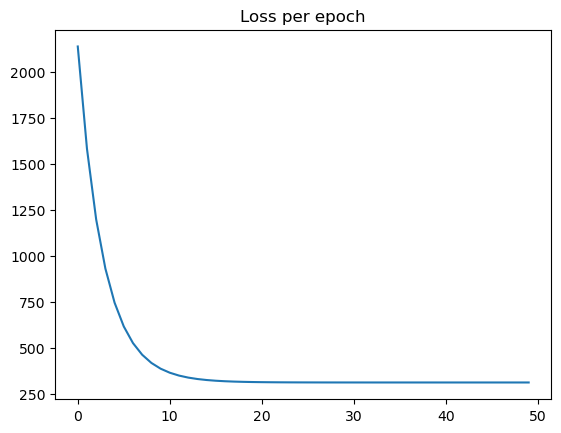

In [104]:
plt.plot(loss_history)
plt.title('Loss per epoch');

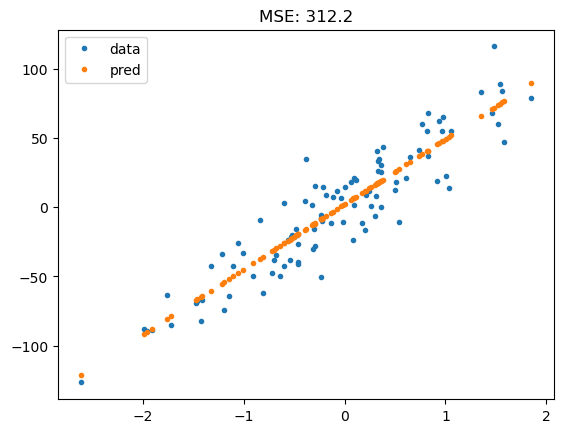

In [105]:
# Vis
fig, ax = plt.subplots()
ax.plot(X_pt.cpu().numpy(), y_pt.cpu().numpy(), ".", label="data")
ax.plot(X_pt.cpu().numpy(), y_hat.cpu().numpy(), ".", label="pred")
ax.set_title(f"MSE: {loss_history[-1]:0.1f}")
ax.legend();

Note: I did gradient descent with all the data. I did not split the data into `train` and `valid` which should be done!

# Wrap up

So when using Pytorch, we would advise you to use the following code as a backbone. 

### 1) Define the model class

Define the model class by extending the torch.nn.Module abstract class. 

In [106]:
# model definition
class LogisticRegressor(nn.Module):
    # define model elements
    def __init__(self, n_inputs):
        super(LogisticRegressor, self).__init__()
        self.layer = nn.Linear(n_inputs, 1)
        self.activation = nn.Sigmoid()
 
    # forward propagate input
    def forward(self, X):
        Z = self.layer(X)
        P = self.activation(Z)
        return P
    
model = LogisticRegressor(32)

### 2) Define loss and optimizer

The training process requires that you define a loss function and an optimization algorithm.

Common loss functions include the following:

* BCELoss: Binary cross-entropy loss for binary classification.

* CrossEntropyLoss: Categorical cross-entropy loss for multi-class classification.

* MSELoss: Mean squared loss for regression.

Common (first order) optimizers include: 

* SGD : stochastic gradient descent. 
* Adam : Similar to SGD but uses the EMA of gradients, and squared gradients to adjust the learning rate. 

In [107]:
# define the optimization
criterion = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

### 3) Training iteration

Each update to the model involves the same general pattern comprised of:

* Clearing the last error gradient. ( stop gradient accumulation )
* A forward pass of the input through the model.
* Calculating the loss for the model output.
* Backpropagating the error through the model.
* Update the model in an effort to reduce loss.

In [108]:
## Toy data.
inputs = torch.zeros( (16,32), dtype=torch.float32)
targets = (torch.randn((16,1), dtype=torch.float32)>0).float()

In [109]:
# clear the gradients
optimizer.zero_grad()
# compute the model output
yhat = model(inputs)
# calculate loss
loss = criterion(yhat, targets)
# credit assignment
loss.backward()
# update model weights
optimizer.step()